## Урок 6. Кейс 2. Данные в страховом бизнесе. EDA

In [833]:
%matplotlib inline

import numpy as np
import pandas as pd
import os
import matplotlib.pyplot as plt
import itertools
import warnings
import plotly.offline as py
import plotly.graph_objs as go
import plotly.tools as tls
import plotly.figure_factory as ff

warnings.filterwarnings("ignore")
py.init_notebook_mode(connected=True)

#### 1. Повторить анализ набора данных WA_Fn-UseC_-Telco-Customer-Churn.csv (желательно придумать какие-то дополнительные признаки)

In [834]:
telcom = pd.read_csv(r"./WA_Fn-UseC_-Telco-Customer-Churn.csv")
telcom.head()

customerID  gender  SeniorCitizen Partner Dependents  tenure PhoneService  \
0  7590-VHVEG  Female              0     Yes         No       1           No   
1  5575-GNVDE    Male              0      No         No      34          Yes   
2  3668-QPYBK    Male              0      No         No       2          Yes   
3  7795-CFOCW    Male              0      No         No      45           No   
4  9237-HQITU  Female              0      No         No       2          Yes   

      MultipleLines InternetService OnlineSecurity  ... DeviceProtection  \
0  No phone service             DSL             No  ...               No   
1                No             DSL            Yes  ...              Yes   
2                No             DSL            Yes  ...               No   
3  No phone service             DSL            Yes  ...              Yes   
4                No     Fiber optic             No  ...               No   

  TechSupport StreamingTV StreamingMovies        Contract PaperlessBilling  \
0          No          No              No  Month-to-month              Yes   
1          No          No              No        One year               No   
2          No          No              No  Month-to-month              Yes   
3         Yes          No              No        One year               No   
4          No          No              No  Month-to-month              Yes   

               PaymentMethod MonthlyCharges  TotalCharges Churn  
0           Electronic check          29.85         29.85    No  
1               Mailed check          56.95        1889.5    No  
2               Mailed check          53.85        108.15   Yes  
3  Bank transfer (automatic)          42.30       1840.75    No  
4           Electronic check          70.70        151.65   Yes  

[5 rows x 21 columns]

In [835]:
print ("Rows     : " ,telcom.shape[0])
print ("Columns  : " ,telcom.shape[1])
print ("\nFeatures : \n" ,telcom.columns.tolist())
print ("\nMissing values :  ", telcom.isnull().sum().values.sum())
print ("\nUnique values :  \n",telcom.nunique())

Rows     :  7043
Columns  :  21

Features : 
 ['customerID', 'gender', 'SeniorCitizen', 'Partner', 'Dependents', 'tenure', 'PhoneService', 'MultipleLines', 'InternetService', 'OnlineSecurity', 'OnlineBackup', 'DeviceProtection', 'TechSupport', 'StreamingTV', 'StreamingMovies', 'Contract', 'PaperlessBilling', 'PaymentMethod', 'MonthlyCharges', 'TotalCharges', 'Churn']

Missing values :   0

Unique values :  
 customerID          7043
gender                 2
SeniorCitizen          2
Partner                2
Dependents             2
tenure                73
PhoneService           2
MultipleLines          3
InternetService        3
OnlineSecurity         3
OnlineBackup           3
DeviceProtection       3
TechSupport            3
StreamingTV            3
StreamingMovies        3
Contract               3
PaperlessBilling       2
PaymentMethod          4
MonthlyCharges      1585
TotalCharges        6531
Churn                  2
dtype: int64


In [836]:
telcom.describe()

SeniorCitizen       tenure  MonthlyCharges
count    7043.000000  7043.000000     7043.000000
mean        0.162147    32.371149       64.761692
std         0.368612    24.559481       30.090047
min         0.000000     0.000000       18.250000
25%         0.000000     9.000000       35.500000
50%         0.000000    29.000000       70.350000
75%         0.000000    55.000000       89.850000
max         1.000000    72.000000      118.750000

In [838]:
# Добавим пару новых признаков

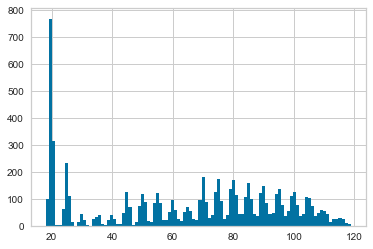

In [839]:
telcom['MonthlyCharges'].hist(bins=100)

In [840]:
telcom['MC_LOW'] = telcom['MonthlyCharges'] < 27.5
telcom['MC_HIGH'] = telcom['MonthlyCharges'] >= 27.5

In [841]:
#Data Manipulation

#Replacing spaces with null values in total charges column
telcom['TotalCharges'] = telcom["TotalCharges"].replace(" ",np.nan)

#Dropping null values from total charges column which contain .15% missing data 
telcom = telcom[telcom["TotalCharges"].notnull()]
telcom = telcom.reset_index()[telcom.columns]

#convert to float type
telcom["TotalCharges"] = telcom["TotalCharges"].astype(float)

#replace 'No internet service' to No for the following columns
replace_cols = [ 'OnlineSecurity', 'OnlineBackup', 'DeviceProtection',
                'TechSupport','StreamingTV', 'StreamingMovies']
for i in replace_cols : 
    telcom[i]  = telcom[i].replace({'No internet service' : 'No'})
    
#replace values
telcom["SeniorCitizen"] = telcom["SeniorCitizen"].replace({1:"Yes",0:"No"})

#Tenure to categorical column
def tenure_lab(telcom) :
    
    if telcom["tenure"] <= 12 :
        return "Tenure_0-12"
    elif (telcom["tenure"] > 12) & (telcom["tenure"] <= 24 ):
        return "Tenure_12-24"
    elif (telcom["tenure"] > 24) & (telcom["tenure"] <= 48) :
        return "Tenure_24-48"
    elif (telcom["tenure"] > 48) & (telcom["tenure"] <= 60) :
        return "Tenure_48-60"
    elif telcom["tenure"] > 60 :
        return "Tenure_gt_60"
telcom["tenure_group"] = telcom.apply(lambda telcom:tenure_lab(telcom),
                                      axis = 1)

#Separating churn and non churn customers
churn     = telcom[telcom["Churn"] == "Yes"]
not_churn = telcom[telcom["Churn"] == "No"]

#Separating catagorical and numerical columns
Id_col     = ['customerID']
target_col = ["Churn"]
cat_cols   = telcom.nunique()[telcom.nunique() < 6].keys().tolist()
cat_cols   = [x for x in cat_cols if x not in target_col]
num_cols   = [x for x in telcom.columns if x not in cat_cols + target_col + Id_col]

In [842]:
#labels
lab = telcom["Churn"].value_counts().keys().tolist()
#values
val = telcom["Churn"].value_counts().values.tolist()

trace = go.Pie(labels = lab ,
               values = val ,
               marker = dict(colors =  [ 'royalblue' ,'lime'],
                             line = dict(color = "white",
                                         width =  1.3)
                            ),
               rotation = 90,
               hoverinfo = "label+value+text",
               hole = .5
              )
layout = go.Layout(dict(title = "Customer attrition in data",
                        plot_bgcolor  = "rgb(243,243,243)",
                        paper_bgcolor = "rgb(243,243,243)",
                       )
                  )

data = [trace]
fig = go.Figure(data = data,layout = layout)
py.iplot(fig)

In [843]:
#function  for pie plot for customer attrition types
def plot_pie(column) :
    
    trace1 = go.Pie(values  = churn[column].value_counts().values.tolist(),
                    labels  = churn[column].value_counts().keys().tolist(),
                    hoverinfo = "label+percent+name",
                    domain  = dict(x = [0,.48]),
                    name    = "Churn Customers",
                    marker  = dict(line = dict(width = 2,
                                               color = "rgb(243,243,243)")
                                  ),
                    hole    = .6
                   )
    trace2 = go.Pie(values  = not_churn[column].value_counts().values.tolist(),
                    labels  = not_churn[column].value_counts().keys().tolist(),
                    hoverinfo = "label+percent+name",
                    marker  = dict(line = dict(width = 2,
                                               color = "rgb(243,243,243)")
                                  ),
                    domain  = dict(x = [.52,1]),
                    hole    = .6,
                    name    = "Non churn customers" 
                   )


    layout = go.Layout(dict(title = column + " distribution in customer attrition ",
                            plot_bgcolor  = "rgb(243,243,243)",
                            paper_bgcolor = "rgb(243,243,243)",
                            annotations = [dict(text = "churn customers",
                                                font = dict(size = 13),
                                                showarrow = False,
                                                x = .15, y = .5),
                                           dict(text = "Non churn customers",
                                                font = dict(size = 13),
                                                showarrow = False,
                                                x = .88,y = .5
                                               )
                                          ]
                           )
                      )
    data = [trace1,trace2]
    fig  = go.Figure(data = data,layout = layout)
    py.iplot(fig)


#function  for histogram for customer attrition types
def histogram(column) :
    trace1 = go.Histogram(x  = churn[column],
                          histnorm= "percent",
                          name = "Churn Customers",
                          marker = dict(line = dict(width = .5,
                                                    color = "black"
                                                    )
                                        ),
                         opacity = .9 
                         ) 
    
    trace2 = go.Histogram(x  = not_churn[column],
                          histnorm = "percent",
                          name = "Non churn customers",
                          marker = dict(line = dict(width = .5,
                                              color = "black"
                                             )
                                 ),
                          opacity = .9
                         )
    
    data = [trace1,trace2]
    layout = go.Layout(dict(title =column + " distribution in customer attrition ",
                            plot_bgcolor  = "rgb(243,243,243)",
                            paper_bgcolor = "rgb(243,243,243)",
                            xaxis = dict(gridcolor = 'rgb(255, 255, 255)',
                                             title = column,
                                             zerolinewidth=1,
                                             ticklen=5,
                                             gridwidth=2
                                            ),
                            yaxis = dict(gridcolor = 'rgb(255, 255, 255)',
                                             title = "percent",
                                             zerolinewidth=1,
                                             ticklen=5,
                                             gridwidth=2
                                            ),
                           )
                      )
    fig  = go.Figure(data=data,layout=layout)
    
    py.iplot(fig)
    
#function  for scatter plot matrix  for numerical columns in data
def scatter_matrix(df)  :
    
    df  = df.sort_values(by = "Churn" ,ascending = True)
    classes = df["Churn"].unique().tolist()
    classes
    
    class_code  = {classes[k] : k for k in range(2)}
    class_code

    color_vals = [class_code[cl] for cl in df["Churn"]]
    color_vals

    pl_colorscale = "Portland"

    pl_colorscale

    text = [df.loc[k,"Churn"] for k in range(len(df))]
    text

    trace = go.Splom(dimensions = [dict(label  = "tenure",
                                       values = df["tenure"]),
                                  dict(label  = 'MonthlyCharges',
                                       values = df['MonthlyCharges']),
                                  dict(label  = 'TotalCharges',
                                       values = df['TotalCharges'])],
                     text = text,
                     marker = dict(color = color_vals,
                                   colorscale = pl_colorscale,
                                   size = 3,
                                   showscale = False,
                                   line = dict(width = .1,
                                               color='rgb(230,230,230)'
                                              )
                                  )
                    )
    axis = dict(showline  = True,
                zeroline  = False,
                gridcolor = "#fff",
                ticklen   = 4
               )
    
    layout = go.Layout(dict(title  = 
                            "Scatter plot matrix for Numerical columns for customer attrition",
                            autosize = False,
                            height = 800,
                            width  = 800,
                            dragmode = "select",
                            hovermode = "closest",
                            plot_bgcolor  = 'rgba(240,240,240, 0.95)',
                            xaxis1 = dict(axis),
                            yaxis1 = dict(axis),
                            xaxis2 = dict(axis),
                            yaxis2 = dict(axis),
                            xaxis3 = dict(axis),
                            yaxis3 = dict(axis),
                           )
                      )
    data   = [trace]
    fig = go.Figure(data = data,layout = layout )
    py.iplot(fig)

#for all categorical columns plot pie
for i in cat_cols :
    plot_pie(i)

#for all categorical columns plot histogram    
for i in num_cols :
    histogram(i)

#scatter plot matrix
scatter_matrix(telcom)

In [844]:
#cusomer attrition in tenure groups
tg_ch  =  churn["tenure_group"].value_counts().reset_index()
tg_ch.columns  = ["tenure_group","count"]
tg_nch =  not_churn["tenure_group"].value_counts().reset_index()
tg_nch.columns = ["tenure_group","count"]

#bar - churn
trace1 = go.Bar(x = tg_ch["tenure_group"]  , y = tg_ch["count"],
                name = "Churn Customers",
                marker = dict(line = dict(width = .5,color = "black")),
                opacity = .9)

#bar - not churn
trace2 = go.Bar(x = tg_nch["tenure_group"] , y = tg_nch["count"],
                name = "Non Churn Customers",
                marker = dict(line = dict(width = .5,color = "black")),
                opacity = .9)

layout = go.Layout(dict(title = "Customer attrition in tenure groups",
                        plot_bgcolor  = "rgb(243,243,243)",
                        paper_bgcolor = "rgb(243,243,243)",
                        xaxis = dict(gridcolor = 'rgb(255, 255, 255)',
                                     title = "tenure group",
                                     zerolinewidth=1,ticklen=5,gridwidth=2),
                        yaxis = dict(gridcolor = 'rgb(255, 255, 255)',
                                     title = "count",
                                     zerolinewidth=1,ticklen=5,gridwidth=2),
                       )
                  )
data = [trace1,trace2]
fig  = go.Figure(data=data,layout=layout)
py.iplot(fig)

In [845]:
telcom[['MonthlyCharges', 'TotalCharges','tenure',"tenure_group"]]

#scatter plot monthly charges & total charges by tenure group

def plot_tenure_scatter(tenure_group,color) :
    tracer = go.Scatter(x = telcom[telcom["tenure_group"] == tenure_group]["MonthlyCharges"],
                        y = telcom[telcom["tenure_group"] == tenure_group]["TotalCharges"],
                        mode = "markers",marker = dict(line = dict(color = "black",
                                                                   width = .2),
                                                       size = 4 , color = color,
                                                       symbol = "diamond-dot",
                                                      ),
                        name = tenure_group,
                        opacity = .9
                       )
    return tracer

#scatter plot monthly charges & total charges by churn group
def plot_churncharges_scatter(churn,color) :
    tracer = go.Scatter(x = telcom[telcom["Churn"] == churn]["MonthlyCharges"],
                        y = telcom[telcom["Churn"] == churn]["TotalCharges"],
                        mode = "markers",marker = dict(line = dict(color = "black",
                                                                   width = .2),
                                                       size = 4 , color = color,
                                                       symbol = "diamond-dot",
                                                      ),
                        name = "Churn - " + churn,
                        opacity = .9
                       )
    return tracer

trace1 = plot_tenure_scatter("Tenure_0-12","#FF3300")
trace2 = plot_tenure_scatter("Tenure_12-24","#6666FF")
trace3 = plot_tenure_scatter("Tenure_24-48","#99FF00")
trace4 = plot_tenure_scatter("Tenure_48-60","#996600")
trace5 = plot_tenure_scatter("Tenure_gt_60","grey")
trace6 = plot_churncharges_scatter("Yes","red")
trace7 = plot_churncharges_scatter("No","blue")

data1   = [trace1,trace2,trace3,trace4,trace5] 
data2   = [trace7,trace6]

#layout
def layout_title(title) :
    layout = go.Layout(dict(title = title,
                            plot_bgcolor  = "rgb(243,243,243)",
                            paper_bgcolor = "rgb(243,243,243)",
                            xaxis = dict(gridcolor = 'rgb(255, 255, 255)',
                                         title = "Monthly charges",
                                         zerolinewidth=1,ticklen=5,gridwidth=2),
                            yaxis = dict(gridcolor = 'rgb(255, 255, 255)',
                                         title = "Total Charges",
                                         zerolinewidth=1,ticklen=5,gridwidth=2),
                            height = 600
                           )
                      )
    return layout

layout1  = layout_title("Monthly Charges & Total Charges by Tenure group")
layout2  = layout_title("Monthly Charges & Total Charges by Churn group")
fig1 = go.Figure(data = data1,layout = layout1)
fig2 = go.Figure(data = data2,layout = layout2)
py.iplot(fig1)
py.iplot(fig2)

In [846]:
avg_tgc = telcom.groupby(["tenure_group","Churn"])[["MonthlyCharges",
                                                    "TotalCharges"]].mean().reset_index()

#function for tracing 
def mean_charges(column,aggregate) :
    tracer = go.Bar(x = avg_tgc[avg_tgc["Churn"] == aggregate]["tenure_group"],
                    y = avg_tgc[avg_tgc["Churn"] == aggregate][column],
                    name = aggregate,marker = dict(line = dict(width = 1)),
                    text = "Churn"
                   )
    return tracer

#function for layout
def layout_plot(title,xaxis_lab,yaxis_lab) :
    layout = go.Layout(dict(title = title,
                            plot_bgcolor  = "rgb(243,243,243)",
                            paper_bgcolor = "rgb(243,243,243)",
                            xaxis = dict(gridcolor = 'rgb(255, 255, 255)',title = xaxis_lab,
                                         zerolinewidth=1,ticklen=5,gridwidth=2),
                            yaxis = dict(gridcolor = 'rgb(255, 255, 255)',title = yaxis_lab,
                                         zerolinewidth=1,ticklen=5,gridwidth=2),
                           )
                      )
    return layout
    

#plot1 - mean monthly charges by tenure groups
trace1  = mean_charges("MonthlyCharges","Yes")
trace2  = mean_charges("MonthlyCharges","No")
layout1 = layout_plot("Average Monthly Charges by Tenure groups",
                      "Tenure group","Monthly Charges")
data1   = [trace1,trace2]
fig1    = go.Figure(data=data1,layout=layout1)

#plot2 - mean total charges by tenure groups
trace3  = mean_charges("TotalCharges","Yes")
trace4  = mean_charges("TotalCharges","No")
layout2 = layout_plot("Average Total Charges by Tenure groups",
                      "Tenure group","Total Charges")
data2   = [trace3,trace4]
fig2    = go.Figure(data=data2,layout=layout2)

py.iplot(fig1)
py.iplot(fig2)

In [847]:
##copy data
tel_df = telcom.copy()
#Drop tenure column
#telcom = telcom.drop(columns = "tenure_group",axis = 1)



#data = [trace1,trace2]

In [848]:
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import StandardScaler

#customer id col
Id_col     = ['customerID']
#Target columns
target_col = ["Churn"]
#categorical columns
cat_cols   = telcom.nunique()[telcom.nunique() < 6].keys().tolist()
cat_cols   = [x for x in cat_cols if x not in target_col]
#numerical columns
num_cols   = [x for x in telcom.columns if x not in cat_cols + target_col + Id_col]
#Binary columns with 2 values
bin_cols   = telcom.nunique()[telcom.nunique() == 2].keys().tolist()
#Columns more than 2 values
multi_cols = [i for i in cat_cols if i not in bin_cols]

#Label encoding Binary columns
le = LabelEncoder()
for i in bin_cols :
    telcom[i] = le.fit_transform(telcom[i])
    
#Duplicating columns for multi value columns
telcom = pd.get_dummies(data = telcom,columns = multi_cols )

#Scaling Numerical columns
std = StandardScaler()
scaled = std.fit_transform(telcom[num_cols])
scaled = pd.DataFrame(scaled,columns=num_cols)

#dropping original values merging scaled values for numerical columns
df_telcom_og = telcom.copy()
telcom = telcom.drop(columns = num_cols,axis = 1)
telcom = telcom.merge(scaled,left_index=True,right_index=True,how = "left")

In [849]:
summary = (df_telcom_og[[i for i in df_telcom_og.columns if i not in Id_col]].
           describe().transpose().reset_index())

summary = summary.rename(columns = {"index" : "feature"})
summary = np.around(summary,3)

val_lst = [summary['feature'], summary['count'],
           summary['mean'],summary['std'],
           summary['min'], summary['25%'],
           summary['50%'], summary['75%'], summary['max']]

trace  = go.Table(header = dict(values = summary.columns.tolist(),
                                line = dict(color = ['#506784']),
                                fill = dict(color = ['#119DFF']),
                               ),
                  cells  = dict(values = val_lst,
                                line = dict(color = ['#506784']),
                                fill = dict(color = ["lightgrey",'#F5F8FF'])
                               ),
                  columnwidth = [200,60,100,100,60,60,80,80,80])
layout = go.Layout(dict(title = "Variable Summary"))
figure = go.Figure(data=[trace],layout=layout)
py.iplot(figure)

In [850]:
#correlation
correlation = telcom.corr()
#tick labels
matrix_cols = correlation.columns.tolist()
#convert to array
corr_array  = np.array(correlation)

#Plotting
trace = go.Heatmap(z = corr_array,
                   x = matrix_cols,
                   y = matrix_cols,
                   colorscale = "Viridis",
                   colorbar   = dict(title = "Pearson Correlation coefficient",
                                     titleside = "right"
                                    ) ,
                  )

layout = go.Layout(dict(title = "Correlation Matrix for variables",
                        autosize = False,
                        height  = 720,
                        width   = 800,
                        margin  = dict(r = 0 ,l = 210,
                                       t = 25,b = 210,
                                      ),
                        yaxis   = dict(tickfont = dict(size = 9)),
                        xaxis   = dict(tickfont = dict(size = 9))
                       )
                  )

data = [trace]
fig = go.Figure(data=data,layout=layout)
py.iplot(fig)

In [851]:
from sklearn.decomposition import PCA

pca = PCA(n_components = 2)

X = telcom[[i for i in telcom.columns if i not in Id_col + target_col]]
Y = telcom[target_col + Id_col]

principal_components = pca.fit_transform(X)
pca_data = pd.DataFrame(principal_components,columns = ["PC1","PC2"])
pca_data = pca_data.merge(Y,left_index=True,right_index=True,how="left")
pca_data["Churn"] = pca_data["Churn"].replace({1:"Churn",0:"Not Churn"})

def pca_scatter(target,color) :
    tracer = go.Scatter(x = pca_data[pca_data["Churn"] == target]["PC1"] ,
                        y = pca_data[pca_data["Churn"] == target]["PC2"],
                        name = target,mode = "markers",
                        marker = dict(color = color,
                                      line = dict(width = .5),
                                      symbol =  "diamond-open"),
                        text = ("Customer Id : " + 
                                pca_data[pca_data["Churn"] == target]['customerID'])
                       )
    return tracer

layout = go.Layout(dict(title = "Visualising data with principal components",
                        plot_bgcolor  = "rgb(243,243,243)",
                        paper_bgcolor = "rgb(243,243,243)",
                        xaxis = dict(gridcolor = 'rgb(255, 255, 255)',
                                     title = "principal component 1",
                                     zerolinewidth=1,ticklen=5,gridwidth=2),
                        yaxis = dict(gridcolor = 'rgb(255, 255, 255)',
                                     title = "principal component 2",
                                     zerolinewidth=1,ticklen=5,gridwidth=2),
                        height = 600
                       )
                  )
trace1 = pca_scatter("Churn",'red')
trace2 = pca_scatter("Not Churn",'royalblue')
data = [trace2,trace1]
fig = go.Figure(data=data,layout=layout)
py.iplot(fig)

In [852]:
#separating binary columns
bi_cs = telcom.nunique()[telcom.nunique() == 2].keys()
dat_rad = telcom[bi_cs]

#plotting radar chart for churn and non churn customers(binary variables)
def plot_radar(df,aggregate,title) :
    data_frame = df[df["Churn"] == aggregate] 
    data_frame_x = data_frame[bi_cs].sum().reset_index()
    data_frame_x.columns  = ["feature","yes"]
    data_frame_x["no"]    = data_frame.shape[0]  - data_frame_x["yes"]
    data_frame_x  = data_frame_x[data_frame_x["feature"] != "Churn"]
    
    #count of 1's(yes)
    trace1 = go.Scatterpolar(r = data_frame_x["yes"].values.tolist(),
                             theta = data_frame_x["feature"].tolist(),
                             fill  = "toself",name = "count of 1's",
                             mode = "markers+lines",
                             marker = dict(size = 5)
                            )
    #count of 0's(No)
    trace2 = go.Scatterpolar(r = data_frame_x["no"].values.tolist(),
                             theta = data_frame_x["feature"].tolist(),
                             fill  = "toself",name = "count of 0's",
                             mode = "markers+lines",
                             marker = dict(size = 5)
                            ) 
    layout = go.Layout(dict(polar = dict(radialaxis = dict(visible = True,
                                                           side = "counterclockwise",
                                                           showline = True,
                                                           linewidth = 2,
                                                           tickwidth = 2,
                                                           gridcolor = "white",
                                                           gridwidth = 2),
                                         angularaxis = dict(tickfont = dict(size = 10),
                                                            layer = "below traces"
                                                           ),
                                         bgcolor  = "rgb(243,243,243)",
                                        ),
                            paper_bgcolor = "rgb(243,243,243)",
                            title = title,height = 700))
    
    data = [trace2,trace1]
    fig = go.Figure(data=data,layout=layout)
    py.iplot(fig)

#plot
plot_radar(dat_rad,1,"Churn -  Customers")
plot_radar(dat_rad,0,"Non Churn - Customers")

LogisticRegression(multi_class='ovr', n_jobs=1, solver='liblinear')

 Classification report : 
               precision    recall  f1-score   support

           0       0.83      0.91      0.87      1268
           1       0.68      0.51      0.59       490

    accuracy                           0.80      1758
   macro avg       0.76      0.71      0.73      1758
weighted avg       0.79      0.80      0.79      1758

Accuracy   Score :  0.79806598407281
Area under curve :  0.7110072104551599 



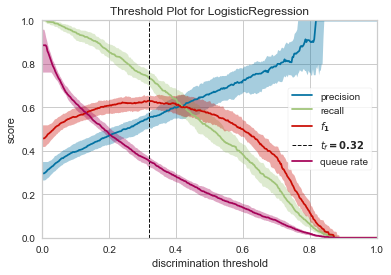

In [853]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import confusion_matrix,accuracy_score,classification_report
from sklearn.metrics import roc_auc_score,roc_curve,scorer
from sklearn.metrics import f1_score
import statsmodels.api as sm
from sklearn.metrics import precision_score,recall_score
from yellowbrick.classifier import DiscriminationThreshold
#splitting train and test data 
train,test = train_test_split(telcom,test_size = .25 ,random_state = 111)
    
##seperating dependent and independent variables
cols    = [i for i in telcom.columns if i not in Id_col + target_col]
train_X = train[cols]
train_Y = train[target_col]
test_X  = test[cols]
test_Y  = test[target_col]

#Function attributes
#dataframe     - processed dataframe
#Algorithm     - Algorithm used 
#training_x    - predictor variables dataframe(training)
#testing_x     - predictor variables dataframe(testing)
#training_y    - target variable(training)
#training_y    - target variable(testing)
#cf - ["coefficients","features"](cooefficients for logistic 
                                 #regression,features for tree based models)

#threshold_plot - if True returns threshold plot for model
    
def telecom_churn_prediction(algorithm,training_x,testing_x,
                             training_y,testing_y,cols,cf,threshold_plot) :
    
    #model
    algorithm.fit(training_x,training_y)
    predictions   = algorithm.predict(testing_x)
    probabilities = algorithm.predict_proba(testing_x)
    #coeffs
    if   cf == "coefficients" :
        coefficients  = pd.DataFrame(algorithm.coef_.ravel())
    elif cf == "features" :
        coefficients  = pd.DataFrame(algorithm.feature_importances_)
        
    column_df     = pd.DataFrame(cols)
    coef_sumry    = (pd.merge(coefficients,column_df,left_index= True,
                              right_index= True, how = "left"))
    coef_sumry.columns = ["coefficients","features"]
    coef_sumry    = coef_sumry.sort_values(by = "coefficients",ascending = False)
    
    print (algorithm)
    print ("\n Classification report : \n",classification_report(testing_y,predictions))
    print ("Accuracy   Score : ",accuracy_score(testing_y,predictions))
    #confusion matrix
    conf_matrix = confusion_matrix(testing_y,predictions)
    #roc_auc_score
    model_roc_auc = roc_auc_score(testing_y,predictions) 
    print ("Area under curve : ",model_roc_auc,"\n")
    fpr,tpr,thresholds = roc_curve(testing_y,probabilities[:,1])
    
    #plot confusion matrix
    trace1 = go.Heatmap(z = conf_matrix ,
                        x = ["Not churn","Churn"],
                        y = ["Not churn","Churn"],
                        showscale  = False,colorscale = "Picnic",
                        name = "matrix")
    
    #plot roc curve
    trace2 = go.Scatter(x = fpr,y = tpr,
                        name = "Roc : " + str(model_roc_auc),
                        line = dict(color = ('rgb(22, 96, 167)'),width = 2))
    trace3 = go.Scatter(x = [0,1],y=[0,1],
                        line = dict(color = ('rgb(205, 12, 24)'),width = 2,
                        dash = 'dot'))
    
    #plot coeffs
    trace4 = go.Bar(x = coef_sumry["features"],y = coef_sumry["coefficients"],
                    name = "coefficients",
                    marker = dict(color = coef_sumry["coefficients"],
                                  colorscale = "Picnic",
                                  line = dict(width = .6,color = "black")))
    
    #subplots
    fig = tls.make_subplots(rows=2, cols=2, specs=[[{}, {}], [{'colspan': 2}, None]],
                            subplot_titles=('Confusion Matrix',
                                            'Receiver operating characteristic',
                                            'Feature Importances'))
    
    fig.append_trace(trace1,1,1)
    fig.append_trace(trace2,1,2)
    fig.append_trace(trace3,1,2)
    fig.append_trace(trace4,2,1)
    
    fig['layout'].update(showlegend=False, title="Model performance" ,
                         autosize = False,height = 900,width = 800,
                         plot_bgcolor = 'rgba(240,240,240, 0.95)',
                         paper_bgcolor = 'rgba(240,240,240, 0.95)',
                         margin = dict(b = 195))
    fig["layout"]["xaxis2"].update(dict(title = "false positive rate"))
    fig["layout"]["yaxis2"].update(dict(title = "true positive rate"))
    fig["layout"]["xaxis3"].update(dict(showgrid = True,tickfont = dict(size = 10),
                                        tickangle = 90))
    py.iplot(fig)
    
    if threshold_plot == True : 
        visualizer = DiscriminationThreshold(algorithm)
        visualizer.fit(training_x,training_y)
        visualizer.poof()
        
logit  = LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False)

telecom_churn_prediction(logit,train_X,test_X,train_Y,test_Y,
                         cols,"coefficients",threshold_plot = True)

LogisticRegression(multi_class='ovr', n_jobs=1, solver='liblinear')

 Classification report : 
               precision    recall  f1-score   support

           0       0.87      0.81      0.84      1268
           1       0.59      0.69      0.64       490

    accuracy                           0.78      1758
   macro avg       0.73      0.75      0.74      1758
weighted avg       0.79      0.78      0.79      1758

Accuracy   Score :  0.7804323094425484
Area under curve :  0.753252752204983 



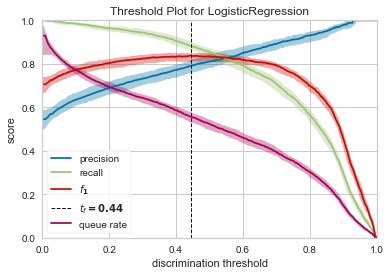

In [854]:
from imblearn.over_sampling import SMOTE

cols    = [i for i in telcom.columns if i not in Id_col+target_col]

smote_X = telcom[cols]
smote_Y = telcom[target_col]

#Split train and test data
smote_train_X,smote_test_X,smote_train_Y,smote_test_Y = train_test_split(smote_X,smote_Y,
                                                                         test_size = .25 ,
                                                                         random_state = 111)

#oversampling minority class using smote
os = SMOTE(random_state = 0)
os_smote_X,os_smote_Y = os.fit_sample(smote_train_X,smote_train_Y)
os_smote_X = pd.DataFrame(data = os_smote_X,columns=cols)
os_smote_Y = pd.DataFrame(data = os_smote_Y,columns=target_col)
###



logit_smote = LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False)

telecom_churn_prediction(logit_smote,os_smote_X,test_X,os_smote_Y,test_Y,
                         cols,"coefficients",threshold_plot = True)

In [855]:
test_X.shape

(1758, 35)

LogisticRegression(multi_class='ovr', n_jobs=1, solver='liblinear')

 Classification report : 
               precision    recall  f1-score   support

           0       0.88      0.70      0.78      1268
           1       0.49      0.76      0.60       490

    accuracy                           0.71      1758
   macro avg       0.69      0.73      0.69      1758
weighted avg       0.77      0.71      0.73      1758

Accuracy   Score :  0.7138794084186576
Area under curve :  0.7284040430052148 



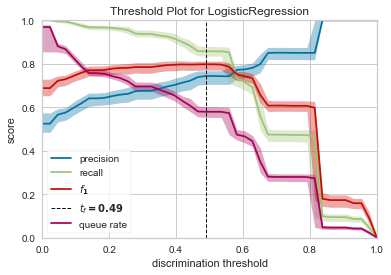

In [856]:
from sklearn.feature_selection import RFE

logit = LogisticRegression()

rfe = RFE(logit,10)
rfe = rfe.fit(os_smote_X,os_smote_Y.values.ravel())

rfe.support_
rfe.ranking_

#identified columns Recursive Feature Elimination
idc_rfe = pd.DataFrame({"rfe_support" :rfe.support_,
                       "columns" : [i for i in telcom.columns if i not in Id_col + target_col],
                       "ranking" : rfe.ranking_,
                      })
cols = idc_rfe[idc_rfe["rfe_support"] == True]["columns"].tolist()


#separating train and test data
train_rf_X = os_smote_X[cols]
train_rf_Y = os_smote_Y
test_rf_X  = test[cols]
test_rf_Y  = test[target_col]

logit_rfe = LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False)
#applying model
telecom_churn_prediction(logit_rfe,train_rf_X,test_rf_X,train_rf_Y,test_rf_Y,
                         cols,"coefficients",threshold_plot = True)

tab_rk = ff.create_table(idc_rfe)
py.iplot(tab_rk)

In [857]:
from sklearn.feature_selection import chi2
from sklearn.feature_selection import SelectKBest

#select columns
cols = [i for i in telcom.columns if i not in Id_col + target_col ]

#dataframe with non negative values
df_x = df_telcom_og[cols]
df_y = df_telcom_og[target_col]

#fit model with k= 3
select = SelectKBest(score_func = chi2,k = 3)
fit    = select.fit(df_x,df_y)

#Summerize scores
print ("scores")
print (fit.scores_)
print ("P - Values")
print (fit.pvalues_)

#create dataframe
score = pd.DataFrame({"features":cols,"scores":fit.scores_,"p_values":fit.pvalues_ })
score = score.sort_values(by = "scores" ,ascending =False)


#createing new label for categorical and numerical columns
score["feature_type"] = np.where(score["features"].isin(num_cols),"Numerical","Categorical")

#plot
trace  = go.Scatter(x = score[score["feature_type"] == "Categorical"]["features"],
                    y = score[score["feature_type"] == "Categorical"]["scores"],
                    name = "Categorial",mode = "lines+markers",
                    marker = dict(color = "red",
                                  line = dict(width =1))
                   )

trace1 = go.Bar(x = score[score["feature_type"] == "Numerical"]["features"],
                y = score[score["feature_type"] == "Numerical"]["scores"],name = "Numerical",
                marker = dict(color = "royalblue",
                              line = dict(width =1)),
                xaxis = "x2",yaxis = "y2"
               )
layout = go.Layout(dict(title = "Scores for Categorical & Numerical features",
                        plot_bgcolor  = "rgb(243,243,243)",
                        paper_bgcolor = "rgb(243,243,243)",
                        xaxis = dict(gridcolor = 'rgb(255, 255, 255)',
                                     tickfont = dict(size =10),
                                     domain=[0, 0.7],
                                     tickangle = 90,zerolinewidth=1,
                                     ticklen=5,gridwidth=2),
                        yaxis = dict(gridcolor = 'rgb(255, 255, 255)',
                                     title = "scores",
                                     zerolinewidth=1,ticklen=5,gridwidth=2),
                        margin = dict(b=200),
                        xaxis2=dict(domain=[0.8, 1],tickangle = 90,
                                    gridcolor = 'rgb(255, 255, 255)'),
                        yaxis2=dict(anchor='x2',gridcolor = 'rgb(255, 255, 255)')
                        )
                  )

data=[trace,trace1]
fig = go.Figure(data=data,layout=layout)
py.iplot(fig)

scores
[2.54297062e-01 1.33482766e+02 8.18577694e+01 1.31271509e+02
 9.29483891e-02 1.47165601e+02 3.12098318e+01 2.02160070e+01
 1.35439602e+02 1.73206148e+01 1.59306111e+01 1.04979224e+02
 2.46200050e+02 7.25184241e+01 3.88864216e+00 8.68247305e-01
 6.51465136e+00 7.11376111e+01 3.72082851e+02 2.85475152e+02
 5.16714004e+02 1.76608724e+02 4.86223101e+02 7.66190658e+01
 9.99725387e+01 4.24113152e+02 4.47251434e+01 4.96199796e+02
 2.38616006e+00 3.12932969e+01 6.29955193e+01 2.87501128e+02
 1.63773281e+04 3.65307468e+03 6.29630810e+05]
P - Values
[6.14065505e-001 7.08954608e-031 1.46240915e-019 2.15953960e-030
 7.60461827e-001 7.21988253e-034 2.31590182e-008 6.91717063e-006
 2.64595220e-031 3.15742928e-005 6.57073922e-005 1.23423173e-024
 1.74939573e-055 1.65479835e-017 4.86137123e-002 3.51440986e-001
 1.06989295e-002 3.33158163e-017 6.58713045e-083 4.81399951e-064
 2.19511926e-114 2.66631661e-040 9.45428638e-108 2.07328356e-018
 1.54524820e-023 3.10584857e-094 2.26727030e-011 6.380052

RandomForestClassifier(criterion='entropy', max_depth=3)

 Classification report : 
               precision    recall  f1-score   support

           0       0.77      0.97      0.86      1268
           1       0.74      0.26      0.38       490

    accuracy                           0.77      1758
   macro avg       0.76      0.61      0.62      1758
weighted avg       0.76      0.77      0.72      1758

Accuracy   Score :  0.7679180887372014
Area under curve :  0.6112212708427219 



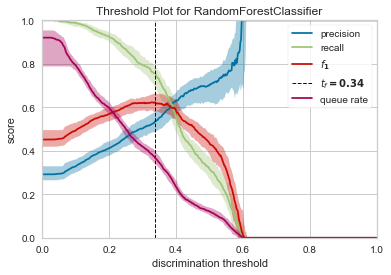

In [858]:
from sklearn.ensemble import RandomForestClassifier

#function attributes
#columns  - column used
#nf_estimators   - The number of trees in the forest.
#estimated_tree  - tree number to be displayed
#maximum_depth   - depth of the tree
#criterion_type  - split criterion type ["gini" or "entropy"]
#Model performance - prints performance of model

def plot_tree_randomforest(columns,nf_estimators,
                           estimated_tree,maximum_depth,
                           criterion_type,model_performance = None) :
    
    dataframe = df_telcom_og[columns + target_col].copy()
    
    #train and test datasets
    rf_x     = dataframe[[i for i in columns if i not in target_col]]
    rf_y     = dataframe[target_col]
    
    #random forest classifier
    rfc   = RandomForestClassifier(n_estimators = nf_estimators,
                                   max_depth = maximum_depth,
                                   criterion = criterion_type,
                                  )
    rfc.fit(rf_x,rf_y)
    
    estimated_tree = rfc.estimators_[estimated_tree]
    
    #graph = Source(tree.export_graphviz(estimated_tree,out_file=None,
    #                                    rounded=True,proportion = False,
    #                        feature_names = columns, 
    #                        precision  = 2,
    #                        class_names=["Not churn","Churn"],
    #                        filled = True))
    #display(graph)
    
    #model performance
    if model_performance == True :
        telecom_churn_prediction(rfc,
                                 rf_x,test_X[columns],
                                 rf_y,test_Y,
                                 columns,"features",threshold_plot = True)
        

cols1 = [ i for i in train_X.columns if i not in target_col + Id_col] 
plot_tree_randomforest(cols1,100,99,3,"entropy",True)

In [859]:
from sklearn.metrics import f1_score
from sklearn.metrics import cohen_kappa_score

#gives model report in dataframe
def model_report(model,training_x,testing_x,training_y,testing_y,name) :
    model.fit(training_x,training_y)
    predictions  = model.predict(testing_x)
    accuracy     = accuracy_score(testing_y,predictions)
    recallscore  = recall_score(testing_y,predictions)
    precision    = precision_score(testing_y,predictions)
    roc_auc      = roc_auc_score(testing_y,predictions)
    f1score      = f1_score(testing_y,predictions) 
    kappa_metric = cohen_kappa_score(testing_y,predictions)
    
    df = pd.DataFrame({"Model"           : [name],
                       "Accuracy_score"  : [accuracy],
                       "Recall_score"    : [recallscore],
                       "Precision"       : [precision],
                       "f1_score"        : [f1score],
                       "Area_under_curve": [roc_auc],
                       "Kappa_metric"    : [kappa_metric],
                      })
    return df

#outputs for every model
model1 = model_report(logit,train_X,test_X,train_Y,test_Y,
                      "Logistic Regression(Baseline_model)")
model2 = model_report(logit_smote,os_smote_X,test_X,os_smote_Y,test_Y,
                      "Logistic Regression(SMOTE)")
model3 = model_report(logit_rfe,train_rf_X,test_rf_X,train_rf_Y,test_rf_Y,
                      "Logistic Regression(RFE)")


rfc = RandomForestClassifier(n_estimators = 1000,
                             random_state = 123,
                             max_depth = 9,
                             criterion = "gini")
model4 = model_report(rfc,train_X,test_X,train_Y,test_Y,
                      "Random Forest Classifier")
rfc = RandomForestClassifier(n_estimators = 1000,
                             random_state = 123,
                             max_depth = 9,
                             criterion = "gini")
model5 = model_report(rfc,os_smote_X,test_X,os_smote_Y,test_Y,
                      "Random Forest Classifier (SMOTE)")
rfc = RandomForestClassifier(n_estimators = 1000,
                             random_state = 123,
                             max_depth = 9,
                             criterion = "gini")
model6 = model_report(rfc,train_rf_X,test_rf_X,train_rf_Y,test_rf_Y,
                      "Random Forest Classifier (RFE)")
#concat all models
model_performances = pd.concat([model1,model2,model3,
                                model4,model5,model6],axis = 0).reset_index()

model_performances = model_performances.drop(columns = "index",axis =1)

table  = ff.create_table(np.round(model_performances,4))

py.iplot(table)

In [860]:
model_performances

Model  Accuracy_score  Recall_score  \
0  Logistic Regression(Baseline_model)        0.798635      0.516327   
1           Logistic Regression(SMOTE)        0.780432      0.691837   
2             Logistic Regression(RFE)        0.713879      0.761224   
3             Random Forest Classifier        0.796359      0.463265   
4     Random Forest Classifier (SMOTE)        0.767918      0.748980   
5       Random Forest Classifier (RFE)        0.718430      0.753061   

   Precision  f1_score  Area_under_curve  Kappa_metric  
0   0.683784  0.588372          0.712028      0.458503  
1   0.590592  0.637218          0.753253      0.481199  
2   0.491436  0.597278          0.728404      0.390963  
3   0.704969  0.559113          0.694172      0.433993  
4   0.562883  0.642732          0.762108      0.475943  
5   0.496635  0.598540          0.729054      0.395467

#### 2. Дополнить список моделей еще как минимум тремя (lightgbm, xgboost, svm, knn, naivebayes, сети, что-то еще)

In [861]:
import xgboost as xgb, lightgbm as lgbm, catboost as catb

In [862]:
cols = [i for i in train_X.columns if i not in target_col + Id_col] 

#### lightgbm

In [863]:
def plot_tree_lightgbm(columns, nf_estimators, maximum_depth):
    model = lgbm.LGBMClassifier(n_estimators = nf_estimators, max_depth = maximum_depth, scale_pos_weight=2.5)
    telecom_churn_prediction(model, train_X, test_X, train_Y, test_Y,
                             columns, "features", threshold_plot=False)
    return model
        
model_lightgbm = plot_tree_lightgbm(cols, 100, 3)

LGBMClassifier(max_depth=3, scale_pos_weight=2.5)

 Classification report : 
               precision    recall  f1-score   support

           0       0.91      0.75      0.82      1268
           1       0.55      0.80      0.65       490

    accuracy                           0.76      1758
   macro avg       0.73      0.77      0.74      1758
weighted avg       0.81      0.76      0.77      1758

Accuracy   Score :  0.7639362912400455
Area under curve :  0.7743739136032962 



#### xgboost

In [864]:
def plot_tree_xgboost(columns, nf_estimators, maximum_depth):
    model = xgb.XGBClassifier(n_estimators = nf_estimators, max_depth = maximum_depth, scale_pos_weight=2.5)
    telecom_churn_prediction(model, train_X, test_X, train_Y, test_Y,
                             columns, "features", threshold_plot=False)
    return model

model_xgboost = plot_tree_xgboost(cols, 100, 3)

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, gamma=0, gpu_id=-1,
              importance_type='gain', interaction_constraints='',
              learning_rate=0.300000012, max_delta_step=0, max_depth=3,
              min_child_weight=1, missing=nan, monotone_constraints='()',
              n_estimators=100, n_jobs=0, num_parallel_tree=1, random_state=0,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=2.5, subsample=1,
              tree_method='exact', validate_parameters=1, verbosity=None)

 Classification report : 
               precision    recall  f1-score   support

           0       0.89      0.78      0.83      1268
           1       0.56      0.75      0.64       490

    accuracy                           0.77      1758
   macro avg       0.73      0.76      0.74      1758
weighted avg       0.80      0.77      0.78      1758

Accuracy   Score :  0.7679180887372014
Area under curve :  0.

#### CatBoost

In [865]:
def plot_tree_catboost(columns, nf_estimators, maximum_depth):
    model = catb.CatBoostClassifier(silent=True, n_estimators = nf_estimators, max_depth = maximum_depth, 
                                    class_weights=[1, 2.5])
    telecom_churn_prediction(model, train_X, test_X, train_Y, test_Y,
                             columns, "features", threshold_plot=False)
    return model

model_catboost = plot_tree_catboost(cols, 100, 3)


 Classification report : 
               precision    recall  f1-score   support

           0       0.90      0.77      0.83      1268
           1       0.57      0.77      0.65       490

    accuracy                           0.77      1758
   macro avg       0.73      0.77      0.74      1758
weighted avg       0.81      0.77      0.78      1758

Accuracy   Score :  0.7713310580204779
Area under curve :  0.7719870598081503 



#### 3. На выходе сформировать единую таблицу метрик качества со всеми моделями

In [866]:
model7 = model_report(model_lightgbm,train_X,test_X,train_Y,test_Y, "lightgbm")
model8 = model_report(model_xgboost,train_X,test_X,train_Y,test_Y, "xgboost")
model9 = model_report(model_catboost,train_X,test_X,train_Y,test_Y, "catboost")
model_performances = pd.concat([model_performances,model7,model8,model9], axis = 0).reset_index()

model_performances = model_performances.drop(columns = "index",axis =1)
table = ff.create_table(np.round(model_performances,4))
model_performances

Model  Accuracy_score  Recall_score  \
0  Logistic Regression(Baseline_model)        0.798635      0.516327   
1           Logistic Regression(SMOTE)        0.780432      0.691837   
2             Logistic Regression(RFE)        0.713879      0.761224   
3             Random Forest Classifier        0.796359      0.463265   
4     Random Forest Classifier (SMOTE)        0.767918      0.748980   
5       Random Forest Classifier (RFE)        0.718430      0.753061   
6                             lightgbm        0.763936      0.797959   
7                              xgboost        0.767918      0.748980   
8                             catboost        0.771331      0.773469   

   Precision  f1_score  Area_under_curve  Kappa_metric  
0   0.683784  0.588372          0.712028      0.458503  
1   0.590592  0.637218          0.753253      0.481199  
2   0.491436  0.597278          0.728404      0.390963  
3   0.704969  0.559113          0.694172      0.433993  
4   0.562883  0.642732          0.762108      0.475943  
5   0.496635  0.598540          0.729054      0.395467  
6   0.553041  0.653300          0.774374      0.483112  
7   0.562883  0.642732          0.762108      0.475943  
8   0.565672  0.653448          0.771987      0.488880

#### 4. Сделать выводы о том, какие модели лучше справляются с задачей прогноза оттока на этой выборке

Лучше справляются модели в которых учитывается балансировка классов

#### 5. Есть ли смысл в этапе отборе признаков с точки зрения повышения качества прогнозов

Попробуем уменьшить количество признаков на примере CatBoost и посмотрим на результат.

In [867]:
feature_importances = pd.DataFrame(model_catboost.feature_importances_, index = train_X.columns, 
                                   columns=['importance']).sort_values('importance', ascending=False)
feature_importances

importance
Contract_Month-to-month                   16.938896
tenure                                    15.190376
MonthlyCharges                            15.121623
TotalCharges                              10.659118
InternetService_Fiber optic                5.680823
Contract_Two year                          5.504812
tenure_group_Tenure_gt_60                  3.653100
PaymentMethod_Electronic check             2.930936
tenure_group_Tenure_0-12                   2.902879
MultipleLines_No                           2.301957
PaperlessBilling                           2.032098
StreamingMovies                            2.001330
SeniorCitizen                              1.578393
OnlineSecurity                             1.494932
Contract_One year                          1.493032
gender                                     1.207245
Dependents                                 1.162036
MC_LOW                                     1.127113
TechSupport                                1.079412
PaymentMethod_Bank transfer (automatic)    0.818163
StreamingTV                                0.779013
OnlineBackup                               0.706521
InternetService_No                         0.629652
InternetService_DSL                        0.568952
PaymentMethod_Mailed check                 0.562305
MultipleLines_Yes                          0.542628
PhoneService                               0.390232
tenure_group_Tenure_24-48                  0.340735
tenure_group_Tenure_48-60                  0.322077
tenure_group_Tenure_12-24                  0.128910
Partner                                    0.054441
PaymentMethod_Credit card (automatic)      0.051958
DeviceProtection                           0.044302
MultipleLines_No phone service             0.000000
MC_HIGH                                    0.000000

In [868]:
# Предыдущий результат был такой:
# Classification report : 
#               precision    recall  f1-score   support
#
#           0       0.90      0.77      0.83      1268
#           1       0.57      0.77      0.65       490
#
#    accuracy                           0.77      1758
#   macro avg       0.73      0.77      0.74      1758
#weighted avg       0.81      0.77      0.78      1758
#
#Accuracy   Score :  0.7713310580204779
#Area under curve :  0.7719870598081503 

In [869]:
cols2 = feature_importances.iloc[0:6].index
model = catb.CatBoostClassifier(silent=True, n_estimators = 100, max_depth = 3, class_weights=[1, 2.5])
telecom_churn_prediction(model, train_X[cols2], test_X[cols2], train_Y, test_Y,
                         cols2, "features", threshold_plot=False)


 Classification report : 
               precision    recall  f1-score   support

           0       0.90      0.74      0.81      1268
           1       0.54      0.79      0.64       490

    accuracy                           0.75      1758
   macro avg       0.72      0.76      0.73      1758
weighted avg       0.80      0.75      0.76      1758

Accuracy   Score :  0.7536973833902162
Area under curve :  0.7635196034249662 



Видно, что качество модели снизилось, поэтому смысла в отборе признаков нет.

#### 5. (Опционально) сделать подбор параметров (без особого усердия) для лучшей (можно нескольких) моделей и проверить качество снова

In [870]:
from sklearn.model_selection import KFold, GridSearchCV

params = {'n_estimators': [5, 10, 50, 100, 150],
          'max_depth': [1, 2, 3, 4, 5]
         }

model = catb.CatBoostClassifier(silent=True, class_weights=[1, 2])
gs = GridSearchCV(model, params, scoring='f1', cv=KFold(n_splits=3, random_state=21, shuffle=True), n_jobs=-1)
gs.fit(train_X, train_Y)
model_catboost_best = gs.best_estimator_

print("best_score:", gs.best_score_)
print("best_params:", gs.best_params_)

telecom_churn_prediction(model_catboost_best, train_X, test_X, train_Y, test_Y,
                         cols, "features", threshold_plot=False)

best_score: 0.63189079729042
best_params: {'max_depth': 1, 'n_estimators': 50}

 Classification report : 
               precision    recall  f1-score   support

           0       0.89      0.81      0.85      1268
           1       0.60      0.74      0.66       490

    accuracy                           0.79      1758
   macro avg       0.74      0.77      0.75      1758
weighted avg       0.81      0.79      0.80      1758

Accuracy   Score :  0.7895335608646189
Area under curve :  0.7739618875941543 



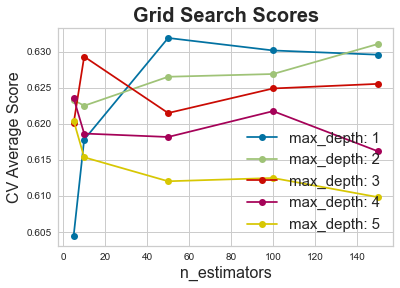

In [871]:
def plot_grid_search(cv_results, grid_param_1, grid_param_2, name_param_1, name_param_2):
    scores_mean = cv_results['mean_test_score']
    scores_mean = np.array(scores_mean).reshape(len(grid_param_2),len(grid_param_1))
    scores_sd = cv_results['std_test_score']
    scores_sd = np.array(scores_sd).reshape(len(grid_param_2),len(grid_param_1))
    _, ax = plt.subplots(1,1)

    for idx, val in enumerate(grid_param_2):
        ax.plot(grid_param_1, scores_mean[idx,:], '-o', label= name_param_2 + ': ' + str(val))

    ax.set_title("Grid Search Scores", fontsize=20, fontweight='bold')
    ax.set_xlabel(name_param_1, fontsize=16)
    ax.set_ylabel('CV Average Score', fontsize=16)
    ax.legend(loc="best", fontsize=15)
    ax.grid('on')
    
plot_grid_search(gs.cv_results_, params['n_estimators'], params['max_depth'], 'n_estimators', 'max_depth')

In [872]:
model10 = model_report(model_catboost_best,train_X, test_X, train_Y, test_Y, "catboost_best")
model_performances = pd.concat([model_performances,model10], axis = 0).reset_index()

model_performances = model_performances.drop(columns = "index",axis =1)
table = ff.create_table(np.round(model_performances,4))
model_performances

Model  Accuracy_score  Recall_score  \
0  Logistic Regression(Baseline_model)        0.798635      0.516327   
1           Logistic Regression(SMOTE)        0.780432      0.691837   
2             Logistic Regression(RFE)        0.713879      0.761224   
3             Random Forest Classifier        0.796359      0.463265   
4     Random Forest Classifier (SMOTE)        0.767918      0.748980   
5       Random Forest Classifier (RFE)        0.718430      0.753061   
6                             lightgbm        0.763936      0.797959   
7                              xgboost        0.767918      0.748980   
8                             catboost        0.771331      0.773469   
9                        catboost_best        0.789534      0.738776   

   Precision  f1_score  Area_under_curve  Kappa_metric  
0   0.683784  0.588372          0.712028      0.458503  
1   0.590592  0.637218          0.753253      0.481199  
2   0.491436  0.597278          0.728404      0.390963  
3   0.704969  0.559113          0.694172      0.433993  
4   0.562883  0.642732          0.762108      0.475943  
5   0.496635  0.598540          0.729054      0.395467  
6   0.553041  0.653300          0.774374      0.483112  
7   0.562883  0.642732          0.762108      0.475943  
8   0.565672  0.653448          0.771987      0.488880  
9   0.599338  0.661792          0.773962      0.511422